In [63]:
import itk
import vtk
import matplotlib.pyplot as plt

# Fonction pour visualiser et lire

In [64]:
def read_file(file_path, image_type):
    """
    Read itk image
    """
    reader = itk.ImageFileReader[image_type].New()
    reader.SetFileName(file_path)
    reader.Update()
    return reader.GetOutput()

In [65]:
image1_path = 'Data/case6_gre1.nrrd'
image2_path = 'Data/case6_gre2.nrrd'

In [66]:
image_1 = read_file(image1_path, itk.Image[itk.ctype('float'), 3])
image_2 = read_file(image2_path, itk.Image[itk.ctype('float'), 3])

print(type(image_1), type(image_2))
image_1.shape, image_2.shape

<class 'itk.itkImagePython.itkImageF3'> <class 'itk.itkImagePython.itkImageF3'>


((176, 256, 256), (176, 256, 256))

In [97]:
def display_images(image1, image2, slice_number):
    """
    Display two images side by side.
    This function is here just to debug for now.
    """
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(image1[slice_number, :, :], cmap='gray')
    plt.title(f"Slice {slice_number}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(image2[slice_number, :, :], cmap='gray')
    plt.title(f"Slice {slice_number}")
    plt.axis('off')
    plt.show()

Partie visualisation

In [106]:
# TODO: dit not found better way to have ITK image to be visualized in VTK
def numpy_to_vtk(numpy_array):
    """
    Convert a numpy array to VTK image
    """
    depthArray = numpy_array.transpose(2, 1, 0).copy()
    res = vtk.vtkImageData()
    res.SetDimensions(depthArray.shape)
    res.AllocateScalars(vtk.VTK_FLOAT, 1)
    
    # Fill array
    for z in range(depthArray.shape[2]):
        for y in range(depthArray.shape[1]):
            for x in range(depthArray.shape[0]):
                res.SetScalarComponentFromFloat(x, y, z, 0, depthArray[x, y, z])
    return res

def visualize_image3D(image):
    """
    Visualize a 3D image
    """
    image_array = itk.GetArrayViewFromImage(image)
    vtk_image = numpy_to_vtk(image_array)

    # Create window and renderer
    renderer = vtk.vtkRenderer()
    window = vtk.vtkRenderWindow()
    window.AddRenderer(renderer)

    # Add interactor to be able to move the camera
    interactor = vtk.vtkRenderWindowInteractor()
    window.SetInteractor(interactor)

    contour = vtk.vtkContourFilter()
    contour.SetInputData(vtk_image)
    contour.SetValue(0, 135)

    contourMapper = vtk.vtkPolyDataMapper()
    contourMapper.SetInputConnection(contour.GetOutputPort())
    contourMapper.ScalarVisibilityOff()

    contourActor = vtk.vtkActor()
    contourActor.SetMapper(contourMapper)

    renderer.AddActor(contourActor)

    window.Render()
    interactor.Start()

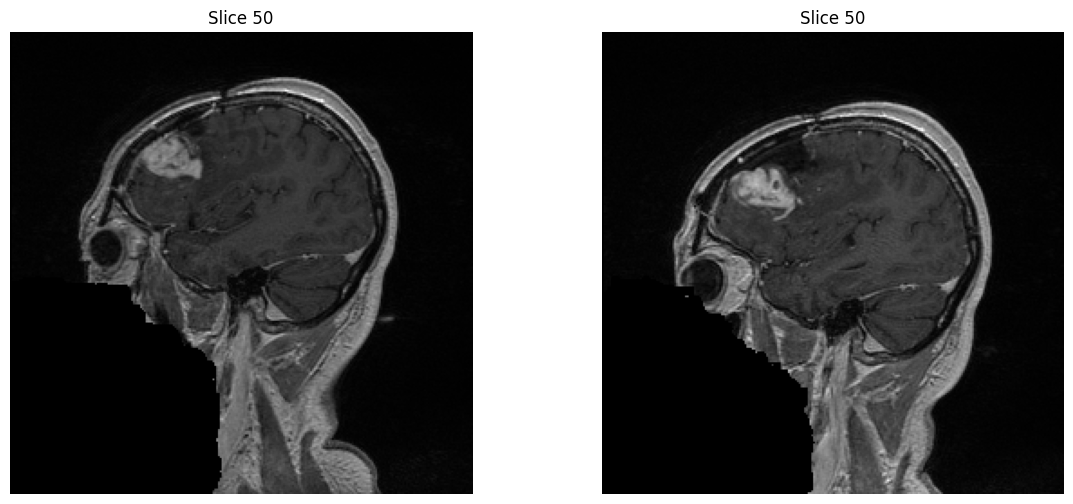

In [98]:
display_images(image_1, image_2, 50)

# Partie 1 : Recalage


Méthode Rigide

In [70]:
def image_registration_rigid(fixed_image=image_1,moving_image=image_2):
    imagetype = itk.Image[itk.ctype('float'), 3]

    #define transform type
    TransformType = itk.VersorRigid3DTransform[itk.D]
    initial_transform = TransformType.New()

    #define optimizer
    optimizer = itk.RegularStepGradientDescentOptimizerv4[itk.D].New(
        LearningRate=0.1,
        MinimumStepLength=0.001,
        RelaxationFactor=0.5,
        NumberOfIterations=200,
        ReturnBestParametersAndValue=True
    )

    #define metric
    metric = itk.MeanSquaresImageToImageMetricv4[imagetype, imagetype].New()

    # define de registration method
    registration = itk.ImageRegistrationMethodv4[imagetype,imagetype].New(
        FixedImage=fixed_image, 
        MovingImage=moving_image, 
        Metric=metric,
        Optimizer=optimizer, 
        InitialTransform=initial_transform,
    )
    registration.SetNumberOfLevels(1)
    registration.SetSmoothingSigmasPerLevel([0])
    registration.SetShrinkFactorsPerLevel([1])
    
    TransformInitializerType = itk.CenteredTransformInitializer[TransformType, imagetype, imagetype]
    initializer = TransformInitializerType.New(
        Transform=initial_transform,
        FixedImage=fixed_image,
        MovingImage=moving_image
    )
    initializer.MomentsOn()
    initializer.InitializeTransform()

    optimizer_scales = itk.OptimizerParameters[itk.D](initial_transform.GetNumberOfParameters())

    optimizer_scales[0] = 1.0
    optimizer_scales[1] = 1.0
    optimizer_scales[2] = 1.0
    optimizer_scales[3] = 1.0 / 1000.0
    optimizer_scales[4] = 1.0 / 1000.0
    optimizer_scales[5] = 1.0 / 1000.0

    optimizer.SetScales(optimizer_scales)

    registration.Update()

    transform = registration.GetTransform()
    final_parameters = transform.GetParameters()
    angle = final_parameters.GetElement(0)
    translation_along_x = final_parameters.GetElement(1)
    translation_along_y = final_parameters.GetElement(2)
    translation_along_z = final_parameters.GetElement(3)
    number_of_iterations = optimizer.GetCurrentIteration()
    best_value = optimizer.GetValue()

    print("Result = ")
    print(" Angle = " + str(angle))
    print(" Translation X = " + str(translation_along_x))
    print(" Translation Y = " + str(translation_along_y))
    print(" Translation Z = " + str(translation_along_z))
    print(" Iterations    = " + str(number_of_iterations))
    print(" Metric value  = " + str(best_value))

    finalTransform = TransformType.New()
    finalTransform.SetFixedParameters(registration.GetOutput().Get().GetFixedParameters())
    finalTransform.SetParameters(registration.GetOutput().Get().GetParameters())

    # Resample the moving image using the final transform to make a 
    resample = itk.ResampleImageFilter[imagetype, imagetype].New()
    resample.SetTransform(finalTransform)
    resample.SetInput(moving_image)
    resample.SetSize(fixed_image.GetLargestPossibleRegion().GetSize())
    resample.SetOutputOrigin(fixed_image.GetOrigin())
    resample.SetOutputSpacing(fixed_image.GetSpacing())
    resample.SetOutputDirection(fixed_image.GetDirection())
    resample.SetDefaultPixelValue(100)
    resample.Update()
    return resample.GetOutput()
    

In [71]:
registered_image_rigide = image_registration_rigid(image_1, image_2)

Result = 
 Angle = 0.0011300177987591449
 Translation X = -0.007763075269564344
 Translation Y = 0.024059544152215197
 Translation Z = -1.1528900645083608
 Iterations    = 141
 Metric value  = 9321.632033205125


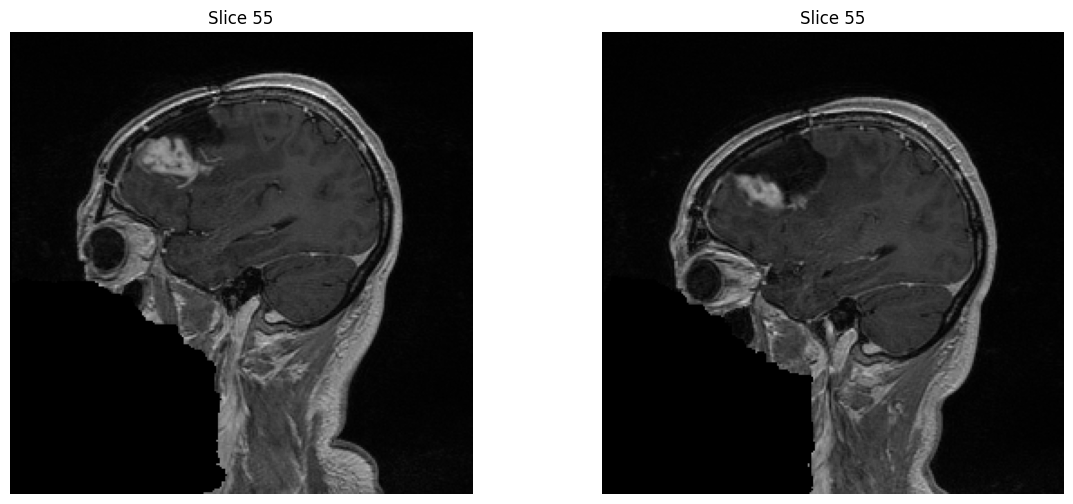

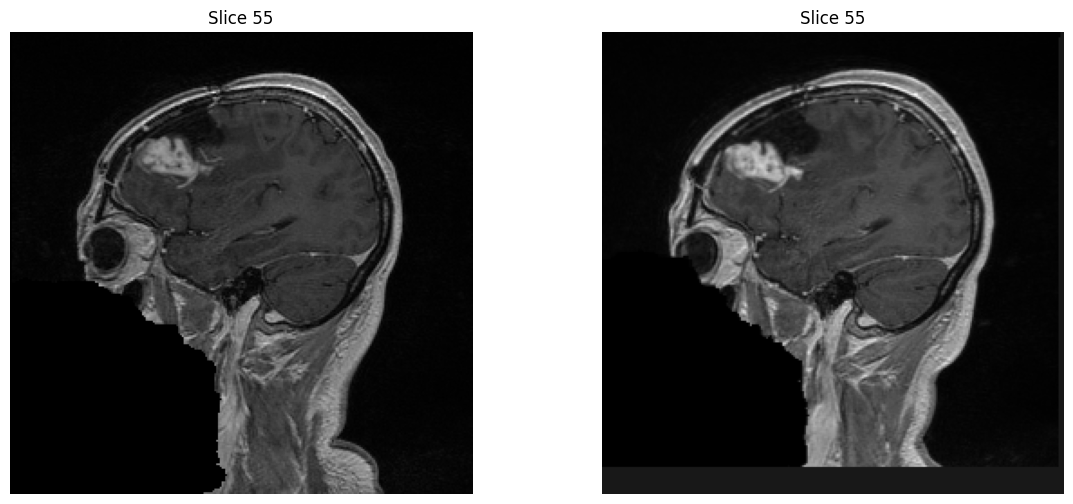

In [99]:
display_images(image_1, image_2, 55)
display_images(image_1, registered_image_rigide, 55)

In [109]:
#visualize_image3D(registered_image_rigide)

In [74]:
itk.imwrite(registered_image_rigide, 'Data/registered_image_rigide.nrrd')

Méthode Transformation Affine


In [75]:
def image_registration_affine(fixed_image=image_1,moving_image=image_2):
    imagetype = itk.Image[itk.ctype('float'), 3]

    #define transform type
    TransformType = itk.AffineTransform[itk.D, 3]
    initial_transform = TransformType.New()

    #define optimizer
    optimizer = itk.RegularStepGradientDescentOptimizer.New(
        MinimumStepLength=0.001,
        RelaxationFactor=0.5,
        NumberOfIterations=500,
        MaximumStepLength=1.0
    )
    optimizer.MinimizeOn()
    
    #define metric
    metric = itk.MeanSquaresImageToImageMetric[imagetype, imagetype].New()

    #define interpolator
    interpolator = itk.LinearInterpolateImageFunction[imagetype, itk.D].New()

    # define de registration method
    registration = itk.ImageRegistrationMethod[imagetype,imagetype].New(
        FixedImage=fixed_image, 
        MovingImage=moving_image,
        FixedImageRegion=fixed_image.GetBufferedRegion(),
        Interpolator=interpolator,
        Metric=metric,
        Optimizer=optimizer, 
        Transform=initial_transform,
        InitialTransformParameters=initial_transform.GetParameters()
    )

    optimizer_scales = itk.OptimizerParameters[itk.D](initial_transform.GetNumberOfParameters())

    for i in range(9):
        optimizer_scales[i] = 1.0
    optimizer_scales[9] = 1.0 / 1000.0
    optimizer_scales[10] = 1.0 / 1000.0
    optimizer_scales[11] = 1.0 / 1000.0

    optimizer.SetScales(optimizer_scales)
    
    registration.Update()
    
    finalParameters = registration.GetOutput().Get().GetParameters()
    maxNumberOfIterations = optimizer.GetCurrentIteration()
    bestValue = optimizer.GetValue()

    print("Result = ")
    print(" Iterations    = " + str(maxNumberOfIterations))
    print(" Metric value  = " + str(bestValue))

    finalTransform = TransformType.New()
    finalTransform.SetParameters(finalParameters)
    finalTransform.SetFixedParameters(initial_transform.GetFixedParameters())

    # Resample the moving image using the final transform to make a 
    resample = itk.ResampleImageFilter[imagetype, imagetype].New()
    resample.SetTransform(finalTransform)
    resample.SetInput(moving_image)
    resample.SetSize(fixed_image.GetLargestPossibleRegion().GetSize())
    resample.SetOutputOrigin(fixed_image.GetOrigin())
    resample.SetOutputSpacing(fixed_image.GetSpacing())
    resample.SetOutputDirection(fixed_image.GetDirection())
    resample.SetDefaultPixelValue(100)
    resample.Update()
    return resample.GetOutput()

In [76]:
registered_image_affine = image_registration_affine(image_1, image_2)

Result = 
 Iterations    = 449
 Metric value  = 6671.612835684993


In [77]:
itk.imwrite(registered_image_affine, 'Data/registered_image_affine.nrrd')

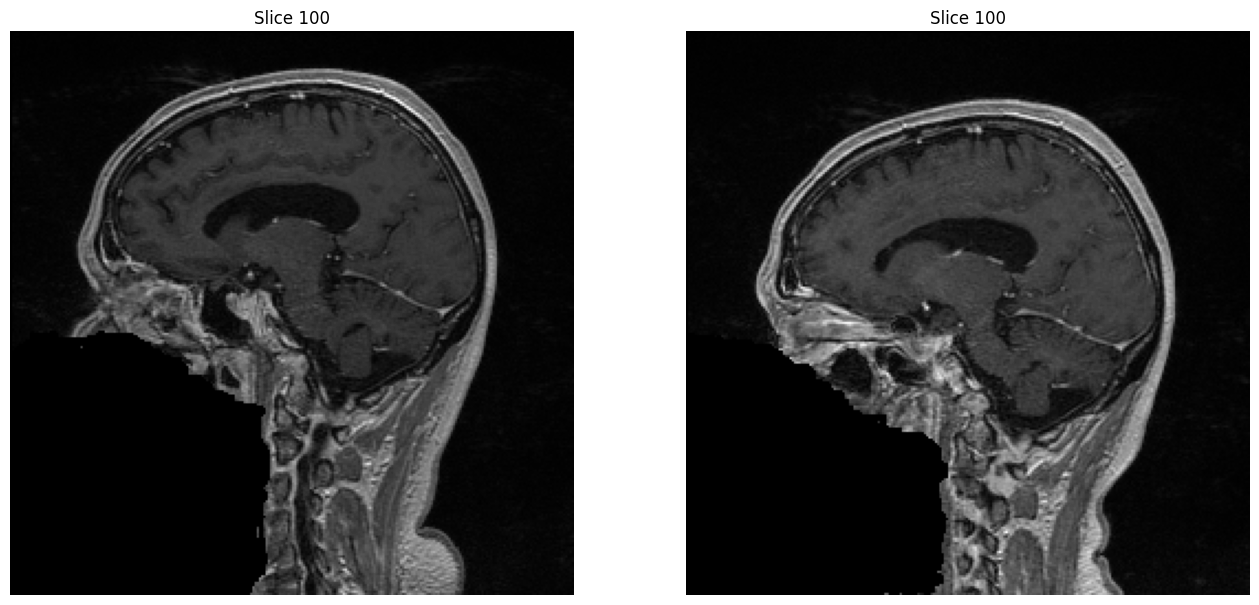

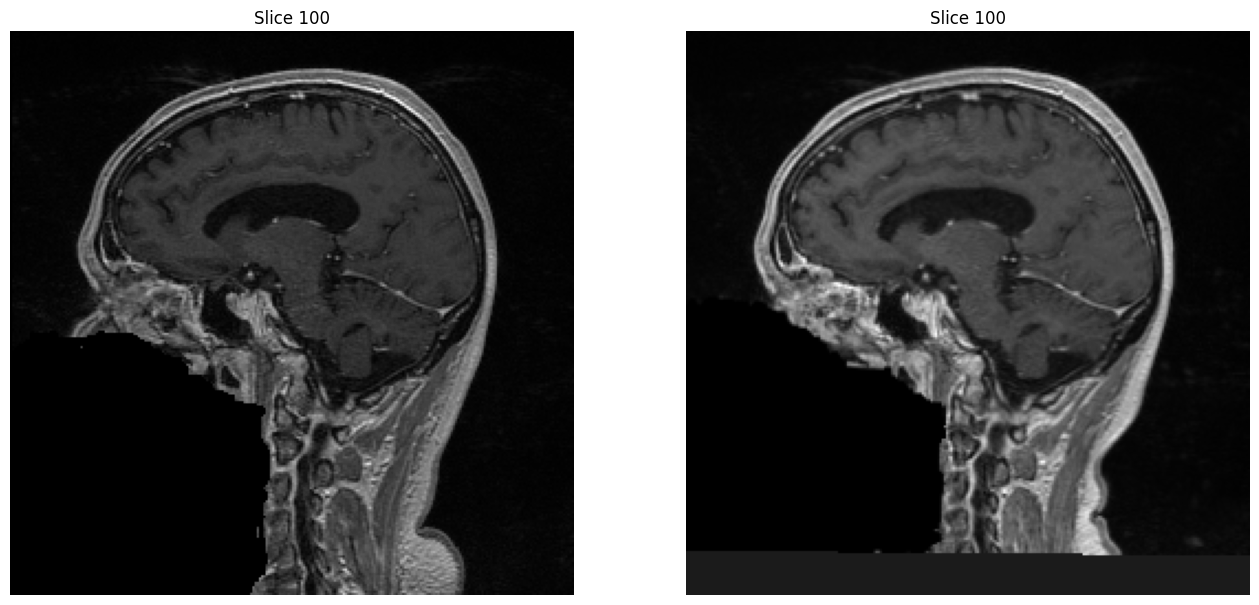

In [78]:
display_images(image_1, image_2, 100)
display_images(image_1, registered_image_affine, 100)

In [79]:
#visualize_image3D(registered_image_affine)

label_image_weights shape expected to have 1 components, but got () components


Les 2 méthode donne un résultat similaire mais en terme de temps , la méthode rigide est environ 2 fois plus rapide. Vérifions quelle méthode est la plus optimale.

In [80]:
def calculate_difference(image1, image2):
    imagetype = itk.Image[itk.F, image1.GetImageDimension()]
    
    resampler = itk.ResampleImageFilter.New(
        Input=image2,
        ReferenceImage=image1,
    )
    resampler.UseReferenceImageOn()
    resampler.Update()

    subtract_filter = itk.SubtractImageFilter[imagetype, imagetype, imagetype].New(
        Input1=image1,
        Input2=resampler.GetOutput()
    )

    abs_diff_filter = itk.AbsImageFilter[imagetype, imagetype].New(
        Input=subtract_filter.GetOutput()
    )
    abs_diff_filter.Update()

    statistics_filter = itk.StatisticsImageFilter[imagetype].New(
        Input=abs_diff_filter.GetOutput()
    )
    statistics_filter.Update()

    return statistics_filter

In [81]:
def print_info_diff(image):
    print(f"Mean: {image.GetMean()}")
    print(f"Variance: {image.GetVariance()}")
    print(f"Sigma: {image.GetSigma()}")
    print(f"SumOfSquares: {image.GetSumOfSquares()}")
    print(f"Standard Deviation: {image.GetSigma()}")
    print(f"Minimum: {image.GetMinimum()}")
    print(f"Maximum: {image.GetMaximum()}")

In [82]:
base_image_diff = calculate_difference(image_1, image_2)
rigid_image_diff = calculate_difference(image_1, registered_image_rigide)
affine_image_diff = calculate_difference(image_1, registered_image_affine)

print("Base Image Difference")
print_info_diff(base_image_diff)
print("\nRigid Image Difference")
print_info_diff(rigid_image_diff)
print("\nAffine Image Difference")
print_info_diff(affine_image_diff)

Base Image Difference
Mean: 119.71184034202078
Variance: 34388.718349000825
Sigma: 185.4419541231186
SumOfSquares: 561948698546.9872
Standard Deviation: 185.4419541231186
Minimum: 0.0
Maximum: 1734.0

Rigid Image Difference
Mean: 51.14967721138341
Variance: 10654.82721334736
Sigma: 103.22222247824041
SumOfSquares: 153073508367.94022
Standard Deviation: 103.22222247824041
Minimum: 0.0
Maximum: 1368.4420166015625

Affine Image Difference
Mean: 46.917091927121554
Variance: 9074.344851899896
Sigma: 95.25935571847994
SumOfSquares: 130056069715.91301
Standard Deviation: 95.25935571847994
Minimum: 0.0
Maximum: 1358.0


Nous pouvons voir que la méthode affine est une meilleure méthode que la méthode rigide car la méthode affine réduit plus que la méthode rigide les différences. De ce fait, nous allons partir sur la méthode affine pour le recalage d'image.

# Partie 2 : Segmentation


In [83]:
def display_for_segmentation(image1,image2,index):
    _, axes = plt.subplots(3, 2, figsize=(8, 10))
    axes[0, 0].imshow(image1[index[0] - 35, :, :], cmap='gray')
    axes[0, 1].imshow(image2[index[0] - 35, :, :], cmap='gray')
    axes[1, 0].imshow(image1[:, index[1], :], cmap='gray')
    axes[1, 1].imshow(image2[:, index[1], :], cmap='gray')
    axes[2, 0].imshow(image1[:, :, index[2] + 30], cmap='gray')
    axes[2, 1].imshow(image2[:, :, index[2] + 30], cmap='gray')

In [84]:
cast_filter = itk.CastImageFilter[registered_image_affine, itk.Image[itk.F, 3]].New()
cast_filter.SetInput(registered_image_affine)
cast_filter.Update()
images_2_resampled = cast_filter.GetOutput()

In [85]:
def smoothing(image):
    smoothing_filter = itk.CurvatureFlowImageFilter.New(image)
    smoothing_filter.SetNumberOfIterations(5)
    smoothing_filter.SetTimeStep(0.125)
    smoothing_filter.Update()
    return smoothing_filter.GetOutput()

In [86]:
image_1_smoothed = smoothing(image_1)
images_2_resampled_smoothed = smoothing(images_2_resampled)

In [87]:
def segmentation(image, lower_threshold, upper_threshold,index):
    imageType = itk.Image[itk.F, 3]
    connectedThreshold = itk.ConnectedThresholdImageFilter[imageType, imageType].New()
    connectedThreshold.SetInput(image)
    connectedThreshold.SetLower(lower_threshold)
    connectedThreshold.SetUpper(upper_threshold)
    connectedThreshold.SetReplaceValue(255)
    connectedThreshold.SetSeed(index)
    connectedThreshold.Update()
    return connectedThreshold.GetOutput()

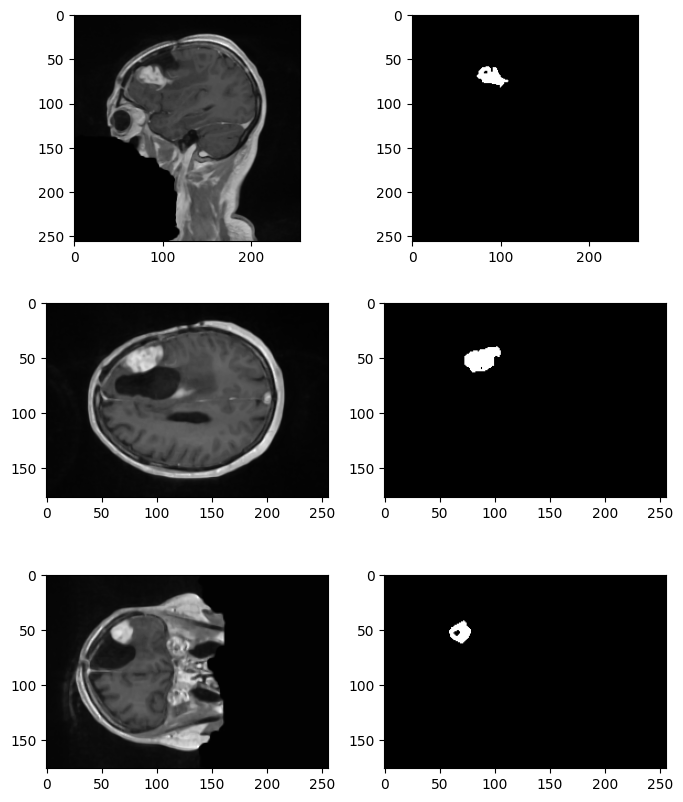

In [88]:
index = [90, 70, 51]
segmented_image_1 = segmentation(image_1_smoothed, 500, 800, index)
segmented_image_2 = segmentation(images_2_resampled_smoothed, 500, 800, index)
    
display_for_segmentation(image_1_smoothed, segmented_image_1, index)

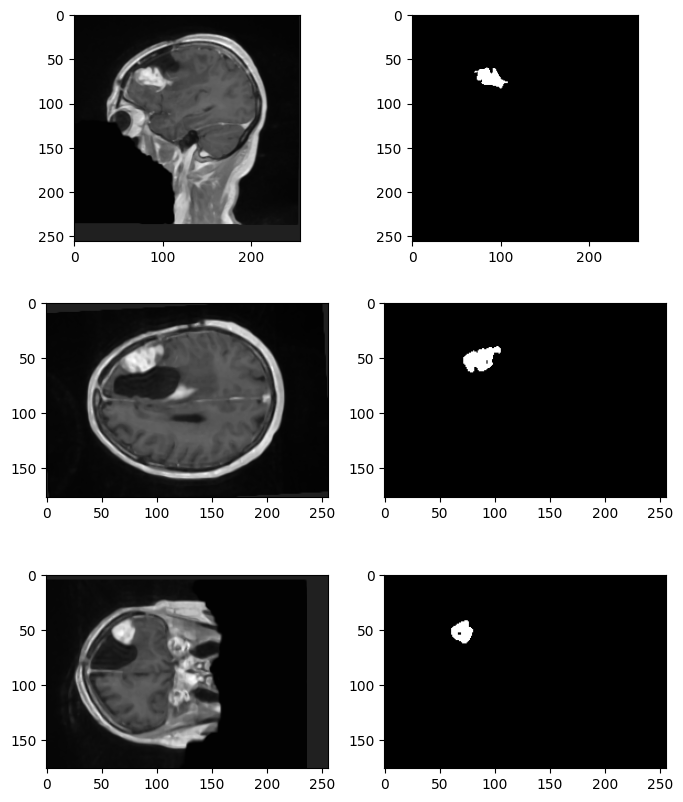

In [89]:
display_for_segmentation(images_2_resampled_smoothed, segmented_image_2, index)

In [90]:
itk.imwrite(segmented_image_1, 'Data/segmented_image_1.nrrd')
itk.imwrite(segmented_image_2, 'Data/segmented_image_2.nrrd')

In [91]:
#visualize_image3D(segmented_image_2)

label_image_weights shape expected to have 1 components, but got () components


# Partie 3 : Comparaison des différences


In [92]:
import numpy as np

def calculate_dice_similarity(image1, image2):
    arr1 = itk.array_from_image(image1)
    arr2 = itk.array_from_image(image2)

    intersection = np.logical_and(arr1, arr2)
    dice_coefficient = 2.0 * intersection.sum() / (arr1.sum() + arr2.sum())

    return dice_coefficient

dice_similarity = calculate_dice_similarity(segmented_image_1, segmented_image_2)
dice_similarity

0.0032379704238164847

In [93]:
def calculate_volume_difference(image1, image2):
    arr1 = itk.array_from_image(image1)
    arr2 = itk.array_from_image(image2)

    voxel_volume = image1.GetSpacing()[0] * image1.GetSpacing()[1] * image1.GetSpacing()[2]

    volume1 = arr1.sum() * voxel_volume
    volume2 = arr2.sum() * voxel_volume
    diff_volume = volume2 - volume1

    return volume1, volume2, diff_volume

volume1, volume2, diff_volume = calculate_volume_difference(segmented_image_1, segmented_image_2)
volume1, volume2, diff_volume

(2046630.0, 2119560.0, 72930.0)

In [94]:
def calculate_intensity_difference(image1, image2):
    arr1 = itk.array_from_image(image1)
    arr2 = itk.array_from_image(image2)

    diff_intensity = np.abs(arr2 - arr1).mean()

    return diff_intensity

diff_intensity = calculate_intensity_difference(segmented_image_1, segmented_image_2)
diff_intensity

0.062963314

In [95]:
def count_white_pixels(image):
    arr = itk.array_from_image(image)
    return arr.sum()

white_pixels1 = count_white_pixels(segmented_image_1)
white_pixels2 = count_white_pixels(segmented_image_2)

print("White pixels 1: " + str(white_pixels1))
print("White pixels 2: " + str(white_pixels2))

print("White pixels difference: " + str(white_pixels2 - white_pixels1))
print("Augmentation factor: " + str(white_pixels2 / white_pixels1))

White pixels 1: 2046630.0
White pixels 2: 2119560.0
White pixels difference: 72930.0
Augmentation factor: 1.0356342


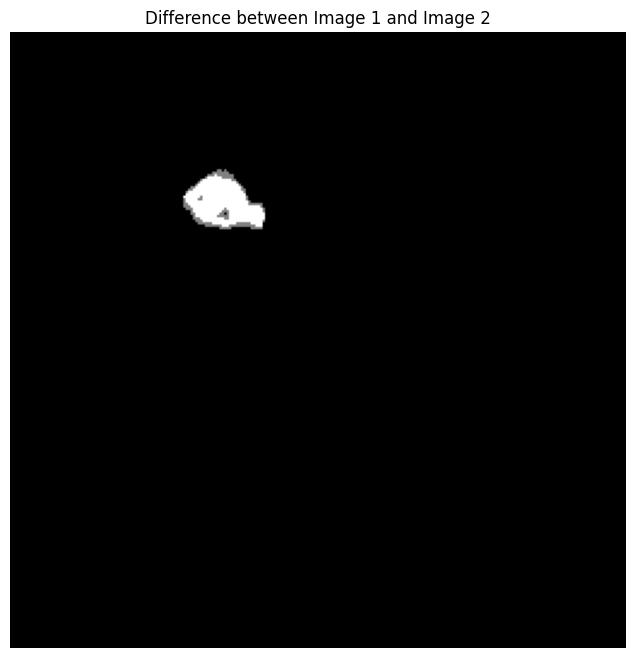

In [107]:
def visualize_image_difference(image1, image2, slice_number):
    arr1 = itk.array_view_from_image(image1)
    arr2 = itk.array_view_from_image(image2)

    diff = np.abs(arr2 + arr1)

    plt.figure(figsize=(8, 8))
    plt.imshow(diff[slice_number, :, :], cmap='gray')
    plt.axis('off')
    plt.title('Difference between Image 1 and Image 2')
    plt.show()

visualize_image_difference(segmented_image_1, segmented_image_2, 50)